In [1]:
import torch
model = torch.hub.load("pytorch/vision", "vit_b_16")


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/root/.cache/torch/hub/pytorch_vision_main/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import torch.backends.cudnn as cudnn
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
import torchvision

from Models.transformer import VisionTransformer as vit
from Models import Conv

from DataLoader import CIFAR100
from DataLoader import MNIST

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
import numpy as np
import random
import utils

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/root/.cache/torch/hub/pytorch_vision_main/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
train_loader, test_loader = MNIST.get_data(64, percent = 1.0)

In [15]:
device = "cuda"
student = torch.load("saved_models/MNIST/using_less_data_resnetBIG18.pth").to(device)
teacher = torch.load("saved_models/MNIST/using_less_data_resnetBIG18.pth").to(device)

In [50]:
optimizer = optim.SGD(teacher.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # 
criterion_MSE = nn.MSELoss().cuda()
criterion_L1 = lambda a,b: torch.sum(a-b)/len(a)
criterion_CE = nn.CrossEntropyLoss()

correct_org = 0
correct_lrp = 0
correct_student = 0

all_data = len(test_loader.dataset)

org_total = []
lrp_total = []
label_total = []
studnet_total = []

model = model.eval()

# with tqdm(f'{correct_org / len(label_total)} , {correct_lrp / len(label_total)}') as pbar:
with tqdm(test_loader, unit='batch') as pbar:
    for img, label in pbar:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)

        input_lrp = utils.get_LRP_img(img, label, teacher, criterion_CE, optimizer, mean=1.5, std = 0.4, mult = 0.4).cuda()
        with torch.no_grad():
            output_lrp = teacher(input_lrp)
            output_org = teacher(img)
            output_student = student(img)
            
            if isinstance(output_lrp, tuple):
                output_lrp = output_lrp[0]
            if isinstance(output_org, tuple):
                output_org = output_org[0]
            if isinstance(output_student, tuple):
                output_student = output_student[0]

        correct_org += sum(label == torch.argmax(output_org, dim=1)).item()
        correct_lrp += sum(label == torch.argmax(output_lrp, dim=1)).item()
        correct_student += sum(label == torch.argmax(output_student, dim=1)).item()

        output_org = output_org.cpu().detach().numpy()
        output_lrp = output_lrp.cpu().detach().numpy()
        output_student = output_student.cpu().detach().numpy()
        label = label.cpu().detach().tolist()

        label_total += label
        org_total.append(output_org)
        lrp_total.append(output_lrp)
        studnet_total.append(output_student)
        
#         acc = correct_org / len(label_total)
        pbar.set_postfix(org = correct_org / len(label_total), lrp = correct_lrp / len(label_total), student = correct_student / len(label_total))
#         print(correct_org / len(label_total) , correct_lrp / len(label_total), len(label_total))


 28%|██▊       | 44/157 [00:13<00:32,  3.43batch/s, lrp=1, org=0.98, student=0.98]  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f31519d88c0>
Traceback (most recent call last):
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/envs/vit-pytorch/lib/python3.7/

KeyboardInterrupt: 

In [51]:
def preprocessing(data, scale=1):
    if isinstance(data, list):
        data = np.concatenate(data)
    data -= np.min(data)
    data /= np.max(data)
    return data * scale

def DrawTSNE(data, label_total, class_num, fontsize=20):
    basic_color = int(255 * 255 * 255 / (class_num))
    
    model=TSNE(n_components=2)
    data=model.fit_transform(data)
    
    labled_data = [[] for _ in range(class_num)] 

    for i, (x,y) in enumerate(data):
        labled_data[label_total[i]].append([x,y])

    labled_data = [np.array(d) for d in labled_data]
    
    for i, d in enumerate(labled_data):
        color = "#"+str(hex(basic_color * int(i + 1)))[2:].zfill(8)
        plt.scatter(d[:, 0], d[:, 1], color = color, s=1, label = str(i))
        plt.text(np.mean(np.sort(d[:,0])),np.mean(np.sort(d[:,1])),s = str(i), color='black', fontsize=fontsize)

    plt.legend()
    plt.show()
    

In [52]:
org_total = preprocessing(org_total)
lrp_total = preprocessing(lrp_total)
studnet_total = preprocessing(studnet_total)

/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


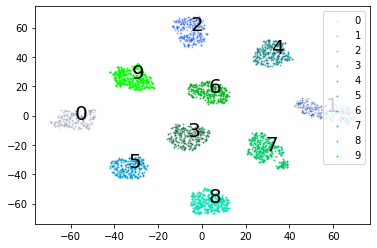

In [54]:
DrawTSNE(lrp_total, label_total, 10)

/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/envs/vit-pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


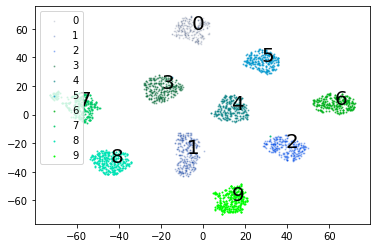

In [53]:
DrawTSNE(lrp_total, label_total, 10)

In [49]:
len(label_total), len(lrp_total)

(1793, 1792)